In [1]:
import os
import glob
import cv2
import imutils

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
CAPTCHAS_FOLDER = '../generated_captcha_images/'
EXTRACTED_LETTER_FOLDER = 'extracted letter/'

In [8]:
captcha_imgs = glob.glob(os.path.join(CAPTCHAS_FOLDER, '*'))

In [22]:
len(captcha_imgs)

9955

In [10]:
assert len(captcha_imgs) == len(os.listdir(CAPTCHAS_FOLDER))

In [11]:
captcha_imgs[0]

'../generated_captcha_images/222X.png'

In [12]:
os.path.basename(captcha_imgs[0])

'222X.png'

In [13]:
os.path.splitext(os.path.basename(captcha_imgs[0]))

('222X', '.png')

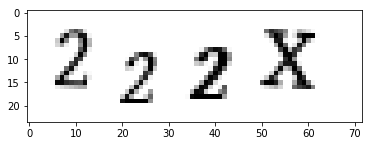

In [14]:
img = cv2.imread(captcha_imgs[0])
plt.imshow(img)

In [15]:
img.shape

(24, 72, 3)

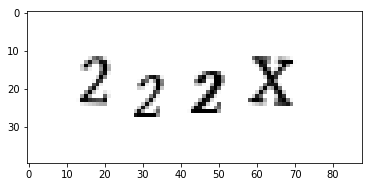

In [16]:
img = cv2.copyMakeBorder(img, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
plt.imshow(img)

In [17]:
img.shape

(40, 88, 3)

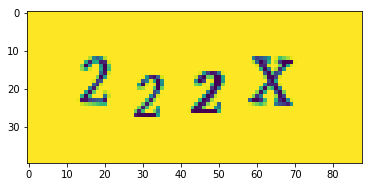

In [18]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

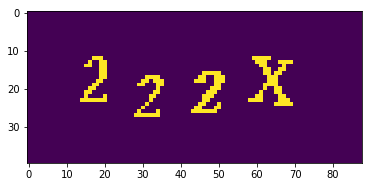

In [19]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

In [20]:
counts = {}

In [23]:
count_err = 0
err_files = []

for i, captcha_img in enumerate(captcha_imgs):
    captcha_text = os.path.splitext(os.path.basename(captcha_img))[0]
    
    img = cv2.imread(captcha_img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours = contours[0] if imutils.is_cv2() else contours[1]
    
    letter_image_regions = []
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        print('Count Error', count_err + 1,'\nERROR FILE NO -', i + 1, captcha_img, ':: Expecting 4 letters but got', len(letter_image_regions), 'letters\n')
        print((captcha_img, captcha_text))
        err_files.append((captcha_img, captcha_text))
        count_err += 1
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(EXTRACTED_LETTER_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1

Count Error 1 
ERROR FILE NO - 91 ../generated_captcha_images/42JM.png :: Expecting 4 letters but got 6 letters

('../generated_captcha_images/42JM.png', '42JM')
Count Error 2 
ERROR FILE NO - 164 ../generated_captcha_images/5CNS.png :: Expecting 4 letters but got 6 letters

('../generated_captcha_images/5CNS.png', '5CNS')
Count Error 3 
ERROR FILE NO - 188 ../generated_captcha_images/5RSW.png :: Expecting 4 letters but got 5 letters

('../generated_captcha_images/5RSW.png', '5RSW')
Count Error 4 
ERROR FILE NO - 292 ../generated_captcha_images/7M2S.png :: Expecting 4 letters but got 5 letters

('../generated_captcha_images/7M2S.png', '7M2S')
Count Error 5 
ERROR FILE NO - 462 ../generated_captcha_images/C6R4.png :: Expecting 4 letters but got 5 letters

('../generated_captcha_images/C6R4.png', 'C6R4')
Count Error 6 
ERROR FILE NO - 478 ../generated_captcha_images/CSDU.png :: Expecting 4 letters but got 5 letters

('../generated_captcha_images/CSDU.png', 'CSDU')
Count Error 7 
ERROR FI

In [25]:
print('Error detecting :: ', count_err)

Error detecting ::  269


In [26]:
assert len(err_files) == count_err

In [29]:
from shutil import copy2

In [30]:
for err_file in err_files:
    copy2(err_file[0], 'error_files/' + err_file[1])